Epoch [100/2000] Critic Loss: -0.0000 Generator Loss: 0.0115
Epoch [200/2000] Critic Loss: -0.0000 Generator Loss: 0.0125
Epoch [300/2000] Critic Loss: -0.0000 Generator Loss: 0.0106
Epoch [400/2000] Critic Loss: 0.0001 Generator Loss: 0.0112
Epoch [500/2000] Critic Loss: -0.0001 Generator Loss: 0.0120
Epoch [600/2000] Critic Loss: -0.0000 Generator Loss: 0.0126
Epoch [700/2000] Critic Loss: 0.0001 Generator Loss: 0.0133
Epoch [800/2000] Critic Loss: 0.0000 Generator Loss: 0.0123
Epoch [900/2000] Critic Loss: 0.0000 Generator Loss: 0.0125
Epoch [1000/2000] Critic Loss: -0.0000 Generator Loss: 0.0121
Epoch [1100/2000] Critic Loss: -0.0001 Generator Loss: 0.0123
Epoch [1200/2000] Critic Loss: 0.0001 Generator Loss: 0.0123
Epoch [1300/2000] Critic Loss: 0.0001 Generator Loss: 0.0120
Epoch [1400/2000] Critic Loss: 0.0000 Generator Loss: 0.0132
Epoch [1500/2000] Critic Loss: 0.0000 Generator Loss: 0.0141
Epoch [1600/2000] Critic Loss: 0.0000 Generator Loss: 0.0135
Epoch [1700/2000] Critic L

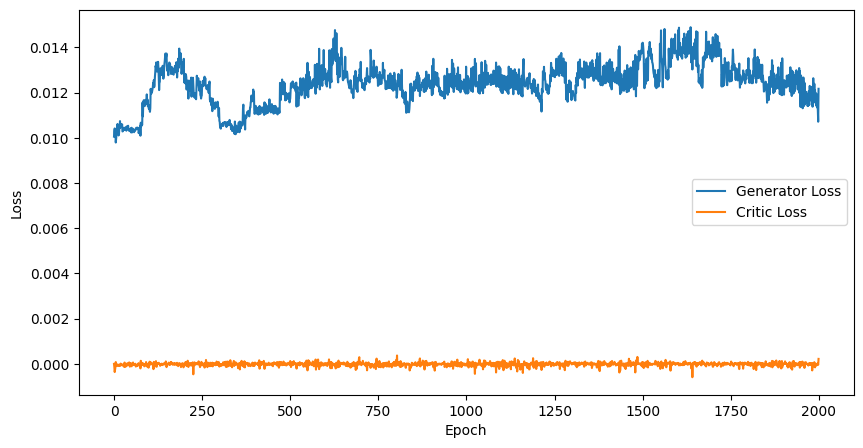

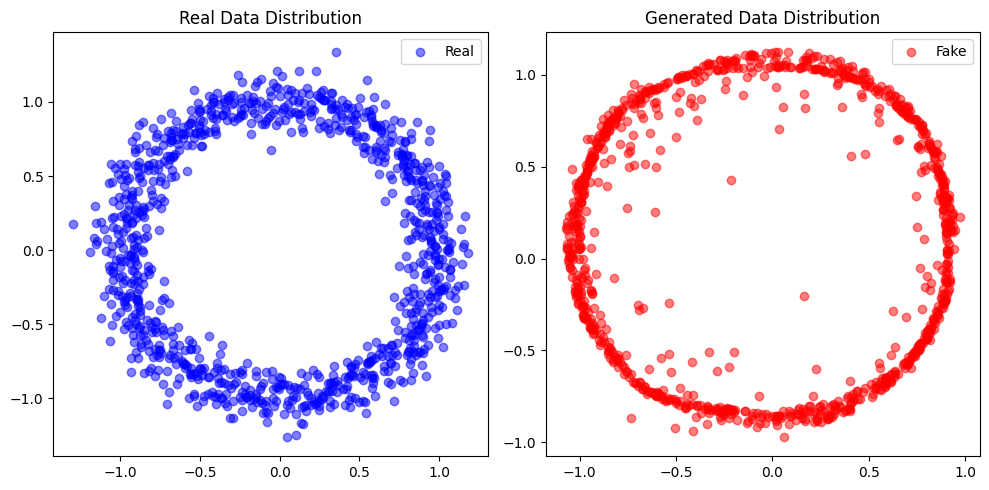

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create a toy dataset of points on a circle with some noise
class CircleDataset(Dataset):
    def __init__(self, n_samples=1000):
        # Generate angles
        theta = np.linspace(0, 2*np.pi, n_samples)
        # Add some noise to radius
        r = np.random.normal(1, 0.1, n_samples)
        # Convert to cartesian coordinates
        self.data = torch.FloatTensor([
            [r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i])]
            for i in range(n_samples)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output 2D points
        )

    def forward(self, z):
        return self.model(z)

# Critic Network (Discriminator in WGAN)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output a single value (no sigmoid)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_wgan(generator, critic, dataloader, num_epochs=10000, n_critic=5, 
               clip_value=0.01, lr=0.00005, latent_dim=2, device="cpu"):
    
    # Optimizers
    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)
    
    # Lists to store losses for plotting
    G_losses = []
    C_losses = []
    
    for epoch in range(num_epochs):
        for i, real_data in enumerate(dataloader):
            batch_size = real_data.size(0)
            real_data = real_data.to(device)

            # Train Critic
            for _ in range(n_critic):
                optimizer_C.zero_grad()
                
                # Generate fake data
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_data = generator(z)
                
                # Compute critic loss
                critic_real = critic(real_data).mean()
                critic_fake = critic(fake_data.detach()).mean()
                critic_loss = -(critic_real - critic_fake)
                
                critic_loss.backward()
                optimizer_C.step()
                
                # Clip critic weights
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)
            
            # Train Generator
            optimizer_G.zero_grad()
            
            # Generate fake data
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            
            # Compute generator loss
            generator_loss = -critic(fake_data).mean()
            
            generator_loss.backward()
            optimizer_G.step()
            
            if i == 0:  # Save losses once per epoch
                G_losses.append(generator_loss.item())
                C_losses.append(critic_loss.item())
                
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Critic Loss: {critic_loss.item():.4f} "
                  f"Generator Loss: {generator_loss.item():.4f}")
    
    return G_losses, C_losses

# Function to visualize results
def plot_results(generator, dataset, n_samples=1000, latent_dim=2):
    generator.eval()
    with torch.no_grad():
        # Generate fake samples
        z = torch.randn(n_samples, latent_dim)
        fake_samples = generator(z).numpy()
        
        # Get real samples
        real_samples = dataset.data.numpy()
        
        # Plot
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(real_samples[:, 0], real_samples[:, 1], c='blue', alpha=0.5, label='Real')
        plt.title('Real Data Distribution')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(fake_samples[:, 0], fake_samples[:, 1], c='red', alpha=0.5, label='Fake')
        plt.title('Generated Data Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Main training routine
def main():
    # Hyperparameters
    batch_size = 64
    latent_dim = 2
    n_critic = 5
    clip_value = 0.01
    lr = 0.00005
    num_epochs = 2000
    
    # Create dataset and dataloader
    dataset = CircleDataset()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize networks
    generator = Generator(latent_dim)
    critic = Critic()
    
    # Train the model
    G_losses, C_losses = train_wgan(
        generator, critic, dataloader,
        num_epochs=num_epochs,
        n_critic=n_critic,
        clip_value=clip_value,
        lr=lr,
        latent_dim=latent_dim
    )
    
    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(C_losses, label='Critic Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot real vs generated distributions
    plot_results(generator, dataset)

if __name__ == "__main__":
    main()